<center> <h1> Homework I </h1></center>
<h2> Task1: Classification & Model Evaluation </h2>
<p> The task asks for a dog's breed classificator which perfectly suits the given dataset. I am going to make a comparison between Logistic Regression, Random Forests and KNN </p>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


<h3> First Step: Cleaning the data </h3><br/>
<p>I will deal with missing values by setting those values to the mean of the coresponding breed. Also, for categorial columns such as:Energy Level, Attention Needs and Coat Lenght where a certain order can be implied I will use Label Encoder to turn them into numerical ones. For those who can not be order such as sex, we will use One Hot Encoding. I will make an exception for Owner's Name because and I will use Label Encoder for it too even tought it does not imply a strict order. After that I will check the correlation matrix to see if I can get rid of some unimportant features.</p>
<p> It can be observed that the dataset is pretty balanced all the 4 dogs' breeds so there is no need for further balancing. Also, I will normalize the dataset due to high values of weight and height which is possible to influence in an unwanted way the model.</p> 

Breed Name
Akita             256
Dalmatian         247
Daschhund         253
French Bulldog    244
dtype: int64


,Breed Name,Weight(g),Height(cm),Energy level,Attention Needs,Coat Lenght,Owner Name,is_sex_female,is_sex_male
Breed Name,1.000000,-0.857031,-0.885390,-0.024499,-0.319464,0.600827,-0.031137,0.021230,-0.021230
Weight(g),-0.857031,1.000000,0.922946,0.324040,0.233467,-0.682179,0.050512,-0.033390,0.033390
Height(cm),-0.885390,0.922946,1.000000,0.306946,0.096355,-0.642822,0.037032,-0.033615,0.033615
Energy level,-0.024499,0.324040,0.306946,1.000000,0.037778,-0.386122,0.067903,-0.062223,0.062223
Attention Needs,-0.319464,0.233467,0.096355,0.037778,1.000000,-0.332403,-0.010065,-0.018519,0.018519
Coat Lenght,0.600827,-0.682179,-0.642822,-0.386122,-0.332403,1.000000,-0.048276,0.025959,-0.025959
Owner Name,-0.031137,0.050512,0.037032,0.067903,-0.010065,-0.048276,1.000000,-0.018684,0.018684
is_sex_female,0.021230,-0.033390,-0.033615,-0.062223,-0.018519,0.025959,-0.018684,1.000000,-1.000000
is_sex_male,-0.021230,0.033390,0.033615,0.062223,0.018519,-0.025959,0.018684,-1.000000,1.000000


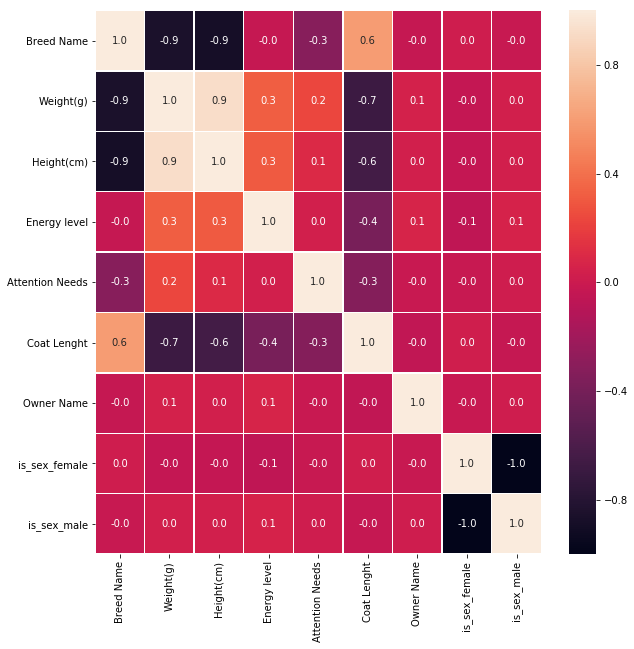

In [601]:
import category_encoders as ce
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


le = preprocessing.LabelEncoder()
dogs = pd.read_csv("Agarici_AV_Eduard_train.csv")
dogs = dogs.drop('Longevity(yrs)', axis = 1)

# categories are pretty balanced so no further balancing
print(dogs.groupby('Breed Name').size())

breed_means = dogs.groupby('Breed Name')['Height(cm)'].mean()

#fill up the missing values by setting weight of a dog to the correspondent mean of its breed
dogs['Height(cm)'] = dogs.apply(lambda row: breed_means[row['Breed Name']] if np.isnan(row['Height(cm)']) else row['Height(cm)'],axis=1)

#normalize weight and height due to the large values
dogs['Weight(g)'] = (dogs['Weight(g)'] - dogs['Weight(g)'].mean()) / dogs['Weight(g)'].std()
dogs['Height(cm)'] = (dogs['Height(cm)'] - dogs['Height(cm)'].mean()) / dogs['Height(cm)'].std()

# label encode those columns where a order can be implied
dogs['Energy level'] = le.fit_transform(dogs['Energy level']) + 1
dogs['Attention Needs'] = le.fit_transform(dogs['Attention Needs']) +1
dogs['Coat Lenght'] = le.fit_transform(dogs['Coat Lenght']) + 1
dogs['Owner Name'] = le.fit_transform(dogs['Owner Name']) + 1
# one hot encode categorical data that can not be ordered
dogs_sex = pd.get_dummies(dogs['Sex'], prefix='is_sex')
dogs = dogs.drop('Sex',axis = 1)
dogs = dogs.join(dogs_sex)

dogs['Breed Name'] = le.fit_transform(dogs['Breed Name'])
target_names =list(le.classes_)

f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(dogs.corr(), annot=True, linewidths=.5, fmt='.1f', ax=ax)

X = dogs.drop('Breed Name', axis = 1).values
y = dogs['Breed Name'].values
dogs.corr()

<p> Since Energy level,Owner Name and Sex have almost 0 correlation with the label I want to predict. These features are unimportant for my predictions so I will drop them. <p>

,Breed Name,Weight(g),Height(cm),Attention Needs,Coat Lenght
Breed Name,1.000000,-0.857031,-0.885390,-0.319464,0.600827
Weight(g),-0.857031,1.000000,0.922946,0.233467,-0.682179
Height(cm),-0.885390,0.922946,1.000000,0.096355,-0.642822
Attention Needs,-0.319464,0.233467,0.096355,1.000000,-0.332403
Coat Lenght,0.600827,-0.682179,-0.642822,-0.332403,1.000000


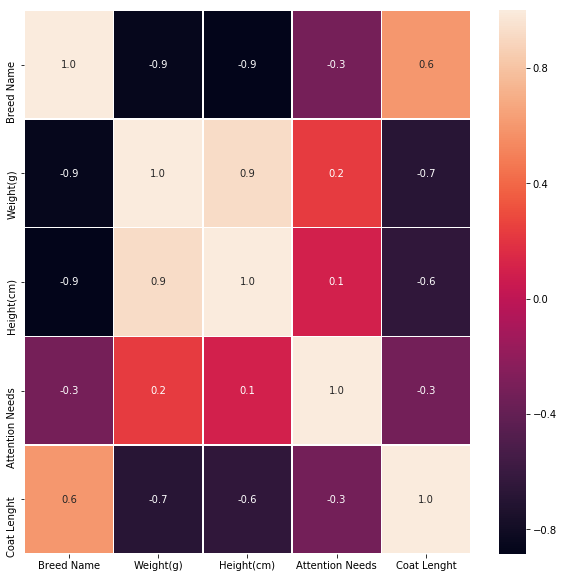

In [590]:
dogs.drop(['is_sex_male','is_sex_female','Energy level','Owner Name'], axis = 1, inplace = True)
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(dogs.corr(), annot=True, linewidths=.5, fmt='.1f', ax=ax)
dogs.corr()

<h3> Step 2 : Tunning Parameters and Model Evaluation </h3>
<p> For tunning parameters I will use KFold to further split my training set in 5 pairs of training and evaluation sets which will help for better tunning the hyperparameters and reduce the chance of overfiting. I will make a table with different values of hyperparameters to argument my final choice.</p>

In [596]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
kf = KFold(n_splits=5, random_state=None, shuffle=False) 

def evaluateModel(model,X,y,target_names):
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=45)
    model.fit(X_train, y_train)
    for j, metrics in enumerate([precision_score,recall_score,f1_score]):
        print(metrics.__name__,':',metrics(y_test,model.predict(X_test),labels=None, pos_label=1, average='weighted'))
    print("classification report :")
    print(classification_report(y_test,model.predict(X_test),target_names = target_names))

def plot_decision_boundary(model, X, y,target_names,model_name):
    
    plt.figure(figsize=(12,8))
    colors = "bryg"
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .02),
                     np.arange(y_min, y_max, .02))

    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)
    cs = plt.contourf(xx,yy,Z, cmap=plt.cm.Paired)
    plt.axis('tight')
  
    for i, color in zip(model.classes_, colors):
        idx = np.where( y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=target_names[i],
                 cmap=plt.cm.Paired,edgecolor='black', s=50, vmin=-.2, vmax=1.2,)
        
    plt.title("Decision boundary of multi-class of " + model_name)
    plt.axis('tight')
    plt.xlabel('most important feature1')
    plt.ylabel('most important feature2')
    
    plt.legend()
    plt.show()

<h3> I. Logistic Regression </h3>

In [583]:
from sklearn.linear_model import LogisticRegression

CC = np.linspace(0.01,30,15)
data = []
for C in CC:
    error = []
    model = LogisticRegression(C = C,solver='newton-cg',max_iter = 10000, multi_class='multinomial', penalty='l2')
    for index,(train_index, test_index) in enumerate(kf.split(X_train)):
        X_train_kFold, X_test_kFold = X_train[train_index], X_train[test_index]
        y_train_kFold, y_test_kFold = y_train[train_index], y_train[test_index]
        model.fit(X_train_kFold,y_train_kFold)  
        score = model.score(X_test_kFold,y_test_kFold)
        error.append(1 - score)
    mean_error = np.average(error);
    data.append([C,mean_error])

tunned_parameters = pd.DataFrame(data,columns=['C','Mean Error'])
plt.figure(figsize=(9,9))
plt.plot(tunned_parameters['C'],tunned_parameters['Mean Error'])
plt.xticks(np.linspace(0,30,16))
plt.plot(np.ones(len(data)) * 2,tunned_parameters['Mean Error'])
plt.xlabel('C', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)


ValueError: Unknown label type: 'continuous'

<h3> Model Evaluation </h3>
<p> As figures reflect in the previous plot, C near 2 will assure a strong performance and also will provide a better regularization than values bigger than 2. </p>



In [555]:
model = LogisticRegression(C=2,penalty='l2', max_iter = 1000, multi_class='multinomial', solver='newton-cg')
evaluateModel(model,X,y,target_names)

precision_score : 0.987964962952934
recall_score : 0.9878787878787879
f1_score : 0.9878853147794804
classification report :
                precision    recall  f1-score   support

         Akita       1.00      0.99      0.99        88
     Dalmatian       0.99      1.00      0.99        86
     Daschhund       0.99      0.98      0.98        87
French Bulldog       0.97      0.99      0.98        69

     micro avg       0.99      0.99      0.99       330
     macro avg       0.99      0.99      0.99       330
  weighted avg       0.99      0.99      0.99       330



<h3> Visualization </h3>
<p> For visualization I will use PCA to reduce initial features vector to a 2 dimensional one keeping the most of their initial variance. </p>


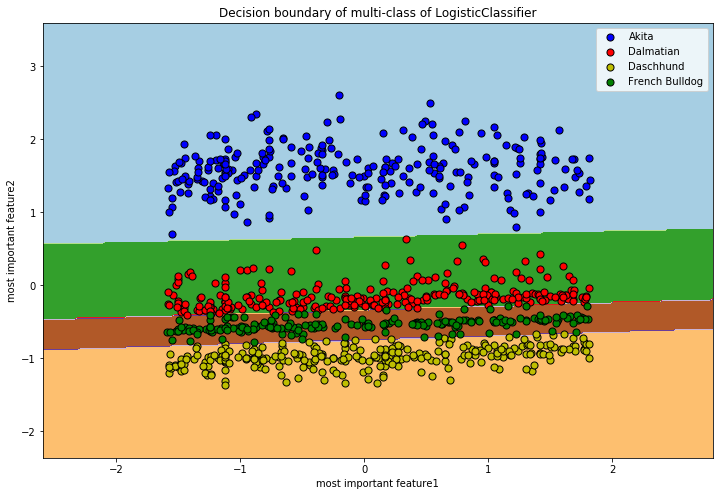

In [556]:
from sklearn.decomposition import PCA
X_reduced = PCA(n_components=2).fit_transform(X)
X_reduced = (X_reduced - X_reduced.mean(axis = 0)) / X_reduced.std(axis =0)
model = LogisticRegression(C=2,penalty='l2', max_iter = 1000, multi_class='multinomial', solver='newton-cg')
model.fit(X_reduced,y)
plot_decision_boundary(model, X_reduced, model.predict(X_reduced),target_names,"LogisticClassifier")

<h3> II. RandomForestClassifier </h3>


Text(0,0.5,'Mean Squared Error')

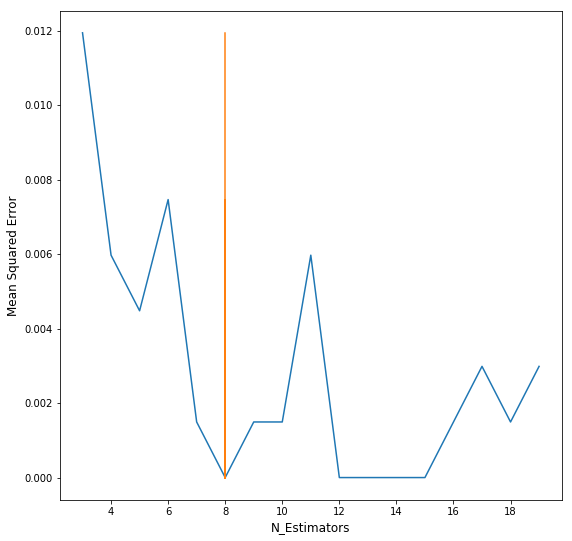

In [557]:
data = []
for n_estimators in range (3, 20):
    error = []
    model = RandomForestClassifier(n_estimators = n_estimators)
    for index,(train_index, test_index) in enumerate(kf.split(X_train)):
        X_train_kFold, X_test_kFold = X_train[train_index], X_train[test_index]
        y_train_kFold, y_test_kFold = y_train[train_index], y_train[test_index]
        model.fit(X_train_kFold,y_train_kFold)  
        score = model.score(X_test_kFold,y_test_kFold)
        error.append(1 - score)
    mean_error = np.average(error);
    data.append([n_estimators,mean_error])

tunned_parameters = pd.DataFrame(data,columns=['N_Estimators','Mean Error'])
plt.figure(figsize=(9,9))
plt.plot(tunned_parameters['N_Estimators'],tunned_parameters['Mean Error'])
plt.plot(np.ones(len(data)) * 8,tunned_parameters['Mean Error'])
plt.xlabel('N_Estimators', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)

<h3> Model Evaluation </h3>
<p> N_Estimators = 8 provides the best score </p>

In [558]:
model = RandomForestClassifier(n_estimators = 8)
evaluateModel(model,X,y,target_names)

precision_score : 1.0
recall_score : 1.0
f1_score : 1.0
classification report :
                precision    recall  f1-score   support

         Akita       1.00      1.00      1.00        88
     Dalmatian       1.00      1.00      1.00        86
     Daschhund       1.00      1.00      1.00        87
French Bulldog       1.00      1.00      1.00        69

     micro avg       1.00      1.00      1.00       330
     macro avg       1.00      1.00      1.00       330
  weighted avg       1.00      1.00      1.00       330



<h3> Visualization </h3>

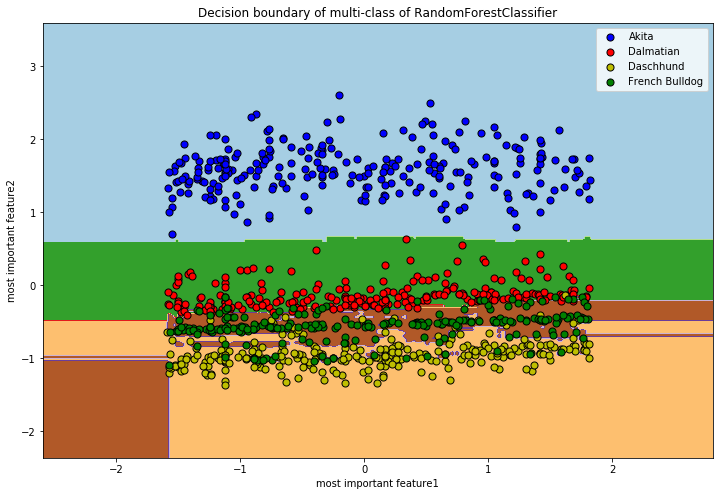

In [559]:
from sklearn.decomposition import PCA
X_reduced = PCA(n_components=2).fit_transform(X)
X_reduced = (X_reduced - X_reduced.mean(axis = 0))/X_reduced.std(axis = 0)
model = RandomForestClassifier(n_estimators = 9)
model.fit(X_reduced,y)
plot_decision_boundary(model, X_reduced, model.predict(X_reduced),target_names, 'RandomForestClassifier')

<h3> III. KNN </h3>

In [597]:
from sklearn.neighbors import KNeighborsClassifier

data = []
for n_neighbors in range(3,20):
    for p in range(1,5):
        model = KNeighborsClassifier(n_neighbors = n_neighbors)
        error = []
        for index,(train_index, test_index) in enumerate(kf.split(X_train)):
            X_train_kFold, X_test_kFold = X_train[train_index], X_train[test_index]
            y_train_kFold, y_test_kFold = y_train[train_index], y_train[test_index]
            model.fit(X_train_kFold,y_train_kFold)  
            score = model.score(X_test_kFold,y_test_kFold)
            error.append(1 - score)
        mean_error = np.average(error);
        data.append([n_neighbors,p,mean_error])

tunned_parameters = pd.DataFrame(data,columns=['N_Neighbors','P','Mean_Error'])
tunned_parameters


,N_Neighbors,P,Mean_Error
0,3,1,0.428358
1,3,2,0.428358
2,3,3,0.428358
3,3,4,0.428358
4,4,1,0.473134
5,4,2,0.473134
6,4,3,0.473134
7,4,4,0.473134
8,5,1,0.505970
9,5,2,0.505970


<h3> Model Evaluating </h3>


In [600]:
best_parameters = tunned_parameters.iloc[tunned_parameters['Mean_Error'].idxmin()]
print('Best Parameters:N_Neighbors',best_parameters['N_Neighbors'],"P",best_parameters['P'])
model = KNeighborsClassifier(n_neighbors = best_parameters['N_Neighbors'].astype(np.int64), p = best_parameters['P'])
evaluateModel(model,X,y, target_names)

Best Parameters:N_Neighbors 3.0 P 1.0
precision_score : 0.7520133591725803
recall_score : 0.7393939393939394
f1_score : 0.7428533732717076
classification report :
                precision    recall  f1-score   support

         Akita       0.90      0.83      0.86        88
     Dalmatian       0.64      0.72      0.68        86
     Daschhund       0.81      0.69      0.75        87
French Bulldog       0.63      0.71      0.67        69

     micro avg       0.74      0.74      0.74       330
     macro avg       0.74      0.74      0.74       330
  weighted avg       0.75      0.74      0.74       330



<h3> Visualization </h3>

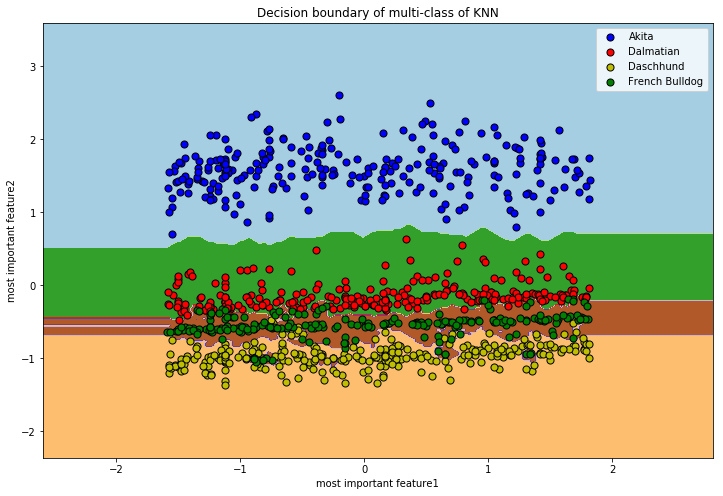

In [566]:
from sklearn.decomposition import PCA
X_reduced = PCA(n_components=2).fit_transform(X)
X_reduced = (X_reduced - X_reduced.mean(axis = 0))/X_reduced.std(axis = 0)
model = KNeighborsClassifier(n_neighbors = best_parameters['N_Neighbors'].astype(np.int64), p = best_parameters['P'])
model.fit(X_reduced,y)
plot_decision_boundary(model, X_reduced, model.predict(X_reduced),target_names, 'KNN')

<h3> Conclusion </h3>
<p>Random Forest and Logistic Regression have solid performances with accuracies around 1, while KNN perform worse than the others 2 with only 0.75 </p>

<h2> Task2: Regression & Model Evaluation </h2>

<h3> First Step: Cleaning the data </h3><br/>
<p> I will perform the same data transformations as I did with the classification problem, but this time  I will keep longevity instead of dog's breed and also normalization is not needed this time.I will see if further correlations emerges </p>

,Weight(g),Height(cm),Longevity(yrs),Energy level,Attention Needs,Coat Lenght,Owner Name,is_sex_female,is_sex_male
Weight(g),1.000000,0.922946,-0.161409,0.324040,0.233467,-0.682179,0.050512,-0.033390,0.033390
Height(cm),0.922946,1.000000,-0.152321,0.306946,0.096355,-0.642822,0.037032,-0.033615,0.033615
Longevity(yrs),-0.161409,-0.152321,1.000000,-0.680744,0.123117,0.242511,-0.028727,0.023982,-0.023982
Energy level,0.324040,0.306946,-0.680744,1.000000,0.037778,-0.386122,0.067903,-0.062223,0.062223
Attention Needs,0.233467,0.096355,0.123117,0.037778,1.000000,-0.332403,-0.010065,-0.018519,0.018519
Coat Lenght,-0.682179,-0.642822,0.242511,-0.386122,-0.332403,1.000000,-0.048276,0.025959,-0.025959
Owner Name,0.050512,0.037032,-0.028727,0.067903,-0.010065,-0.048276,1.000000,-0.018684,0.018684
is_sex_female,-0.033390,-0.033615,0.023982,-0.062223,-0.018519,0.025959,-0.018684,1.000000,-1.000000
is_sex_male,0.033390,0.033615,-0.023982,0.062223,0.018519,-0.025959,0.018684,-1.000000,1.000000


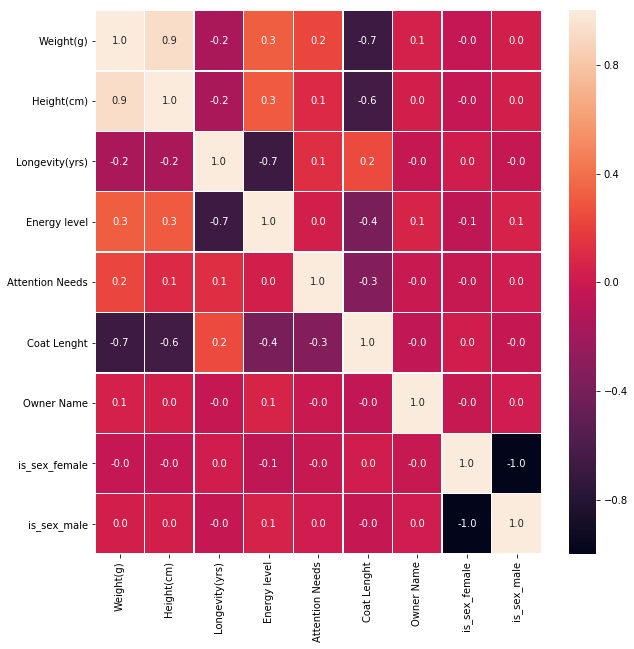

In [567]:
le = preprocessing.LabelEncoder()
dogs = pd.read_csv("Agarici_AV_Eduard_train.csv")

breed_means = dogs.groupby('Breed Name')['Height(cm)'].mean()
#fill up the missing values by setting weight of a dog to the correspondent mean of its breed
dogs['Height(cm)'] = dogs.apply(lambda row: breed_means[row['Breed Name']] if np.isnan(row['Height(cm)']) else row['Height(cm)'],axis=1)

dogs.drop('Breed Name', axis = 1,inplace = True)

# label encode those columns where a order can be implied
dogs['Energy level'] = le.fit_transform(dogs['Energy level']) + 1
dogs['Attention Needs'] = le.fit_transform(dogs['Attention Needs']) +1
dogs['Coat Lenght'] = le.fit_transform(dogs['Coat Lenght']) + 1
dogs['Owner Name'] = le.fit_transform(dogs['Owner Name']) + 1
# one hot encode categorical data that can not be ordered
dogs_sex = pd.get_dummies(dogs['Sex'], prefix='is_sex')
dogs = dogs.drop('Sex',axis = 1)
dogs = dogs.join(dogs_sex)

f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(dogs.corr(), annot=True, linewidths=.5, fmt='.1f', ax=ax)

X = dogs.drop('Longevity(yrs)', axis = 1).values
y = dogs['Longevity(yrs)'].values
dogs.corr()

<h3> I see that longevity is weakly correlated to sex (0,02) so sex will have a little impact on the prediction </h3>


,Weight(g),Height(cm),Longevity(yrs),Energy level,Attention Needs,Coat Lenght
Weight(g),1.000000,0.922946,-0.161409,0.324040,0.233467,-0.682179
Height(cm),0.922946,1.000000,-0.152321,0.306946,0.096355,-0.642822
Longevity(yrs),-0.161409,-0.152321,1.000000,-0.680744,0.123117,0.242511
Energy level,0.324040,0.306946,-0.680744,1.000000,0.037778,-0.386122
Attention Needs,0.233467,0.096355,0.123117,0.037778,1.000000,-0.332403
Coat Lenght,-0.682179,-0.642822,0.242511,-0.386122,-0.332403,1.000000


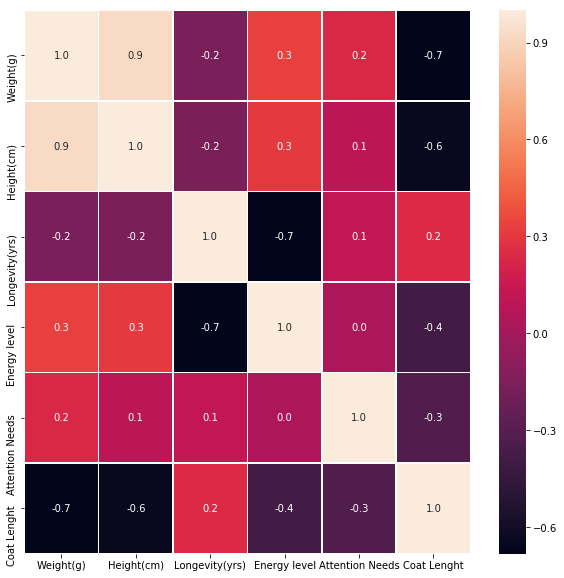

In [568]:
dogs.drop(['is_sex_male','is_sex_female','Owner Name'], axis = 1, inplace = True)
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(dogs.corr(), annot=True, linewidths=.5, fmt='.1f', ax=ax)
dogs.corr()


<h2> Second step : Tunning Hyperparameters and Model evaluation </h2>



In [578]:
from sklearn.metrics import r2_score ,explained_variance_score,mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
kf = KFold(n_splits=4, random_state=None, shuffle=False) 

def evaluateModelRegression(model,X,y):
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=45)
    model.fit(X_train, y_train)
    for j, metrics in enumerate([r2_score , explained_variance_score,mean_squared_error]):
        print(metrics.__name__,':',metrics(y_test,model.predict(X_test)))

def plotRegression(modelName,model):
    plt.figure(figsize=(25,10))
    plt.title(modelName)
    plt.plot(range(1,y_test.size+1),y_test)
    plt.plot(range(1,y_test.size+1),model.predict(X_test))
    plt.legend(['actual label','predicted label'])

<h2> I.1 Ridge Regression </h2

Text(0,0.5,'Mean Squared Error')

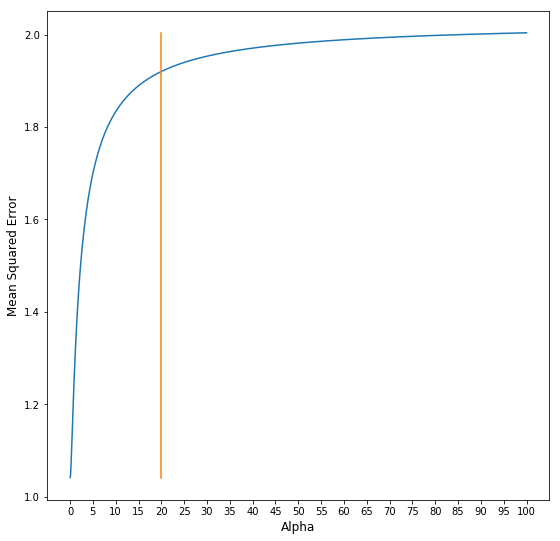

In [570]:
from sklearn.linear_model import Ridge
alphas = np.linspace(0,10**2,1000)
data = []
for alpha in alphas :
    model = Ridge(alpha = alpha, normalize = True)
    errors = []
    for index,(train_index, test_index) in enumerate(kf.split(X_train)):
        X_train_kFold, X_test_kFold = X_train[train_index], X_train[test_index]
        y_train_kFold, y_test_kFold = y_train[train_index], y_train[test_index]
        model.fit(X_train_kFold,y_train_kFold)  
        errors.append(mean_squared_error(y_test_kFold,model.predict(X_test_kFold)))
    data.append([alpha,np.average(errors)])

tunned_parameters = pd.DataFrame(data,columns=['Alpha','Mean Squared Error'])
plt.figure(figsize=(9,9))
plt.plot(tunned_parameters['Alpha'],tunned_parameters['Mean Squared Error'])
plt.plot(np.ones(len(data)) * 20,tunned_parameters['Mean Squared Error'])
plt.xticks(np.linspace(0,100,21))
plt.xlabel('Alpha', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)



<h3> Model evaluation </h3>
<p> I will use alpha = 20 because I want regularization to be strong, but not to force all the coefficients to be almost 0 </p>

In [571]:
model = Ridge(alpha = 20)
model.fit(X_train,y_train)
print("Score:",model.score(X_test,y_test))

evaluateModelRegression(model,X,y)

Score: 0.47386555781934536
r2_score : 0.4816909298610822
explained_variance_score : 0.4892898915956806
mean_squared_error : 1.0273631599123807


<h3> Visualization </h3>

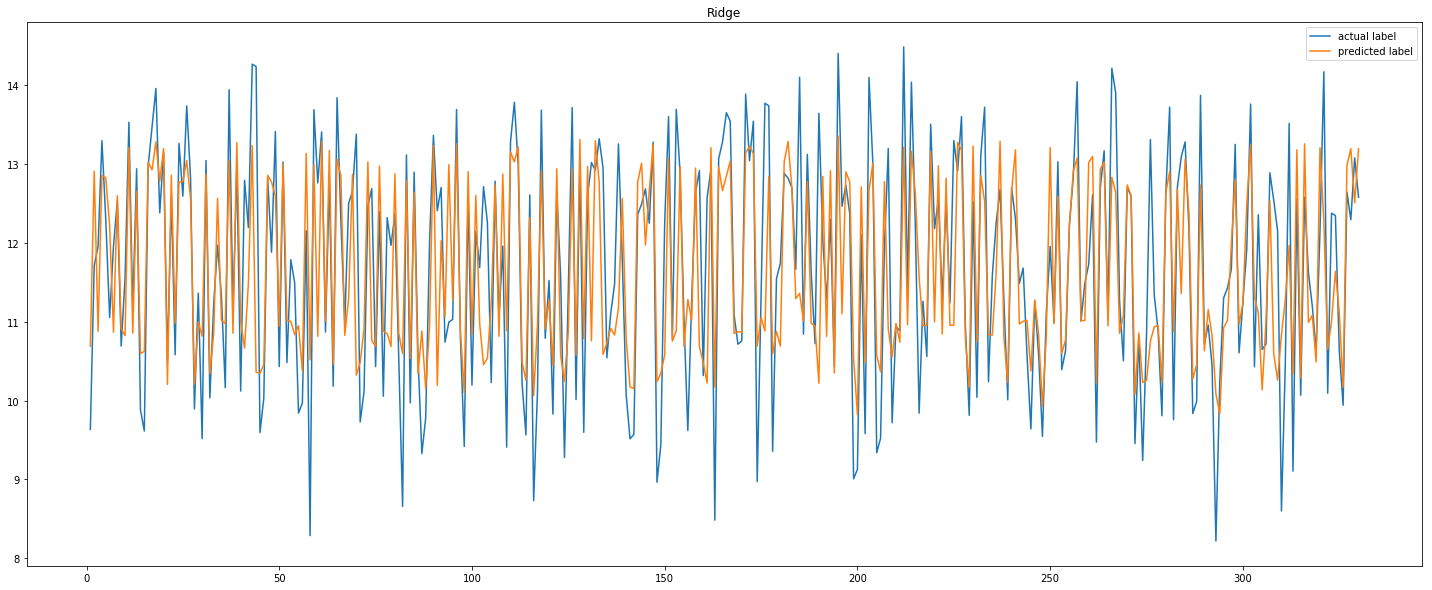

In [581]:
plotRegression("Ridge",model)

<h2> I.2 Lasso Regression </h2

Text(0,0.5,'Mean Squared Error')

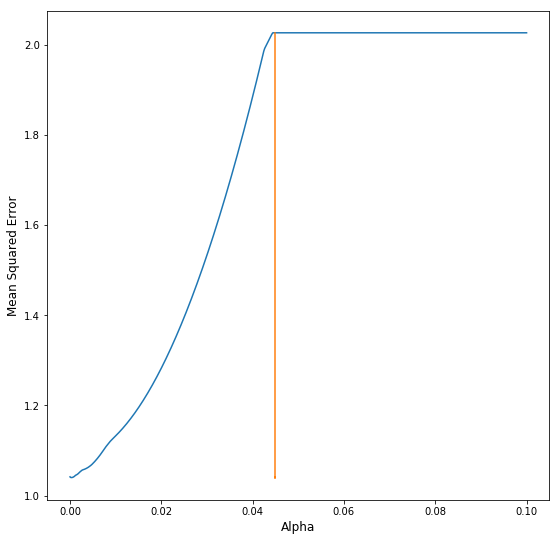

In [573]:
from sklearn.linear_model import Lasso
alphas = np.linspace(10**-5,10**-1,1000)
data = []
for alpha in alphas :
    model = Lasso(alpha = alpha, normalize = True)
    errors = []
    for index,(train_index, test_index) in enumerate(kf.split(X_train)):
        X_train_kFold, X_test_kFold = X_train[train_index], X_train[test_index]
        y_train_kFold, y_test_kFold = y_train[train_index], y_train[test_index]
        model.fit(X_train_kFold,y_train_kFold)  
        errors.append(mean_squared_error(y_test_kFold,model.predict(X_test_kFold)))
    data.append([alpha,np.average(errors)])

tunned_parameters = pd.DataFrame(data,columns=['Alpha','Mean Squared Error'])
plt.figure(figsize=(9,9))
plt.plot(tunned_parameters['Alpha'],tunned_parameters['Mean Squared Error'])
plt.plot(np.ones(len(data)) * 0.045,tunned_parameters['Mean Squared Error'])
plt.xlabel('Alpha', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
#plt.xticks(np.linspace(0,100,21))

<h3>Model evaluation </h3> 

In [574]:
#best_parameters = tunned_parameters.iloc[tunned_parameters['Mean Squared Error'].idxmin()]
#print('Best alpha',best_parameters['Alpha'])

model = Lasso(alpha = 0.045 )
model.fit(X_train,y_train)
print("Score:",model.score(X_test,y_test))
evaluateModelRegression(model,X,y)


Score: 0.47595324926449906
r2_score : 0.47497560740184996
explained_variance_score : 0.48216960136737586
mean_squared_error : 1.0406738953384427


<h3> Visualization </h3>

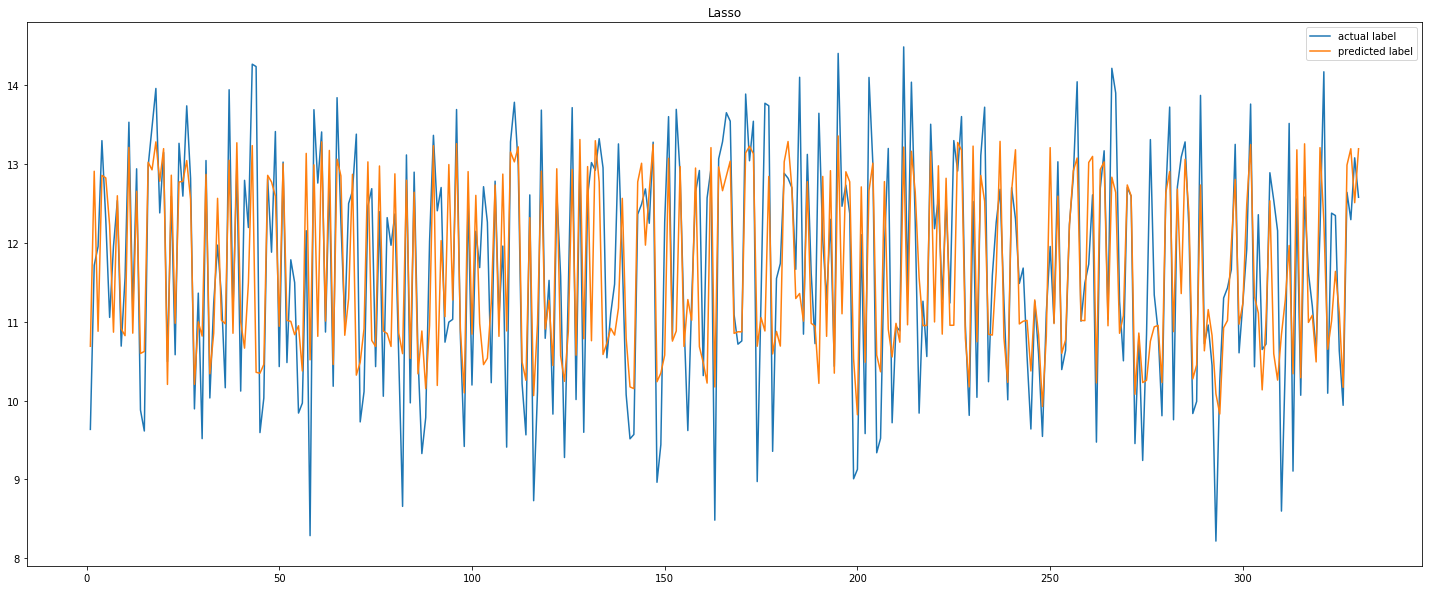

In [580]:
plotRegression("Lasso",model)

<h2> II.KNN Regression </h2>


In [585]:
from sklearn.neighbors import KNeighborsRegressor

data = []
for k in range(3,15):
    for p in range (1,10):
        model = KNeighborsRegressor(n_neighbors = k, p = p)
        errors = []
        for index,(train_index, test_index) in enumerate(kf.split(X_train)):
            X_train_kFold, X_test_kFold = X_train[train_index], X_train[test_index]
            y_train_kFold, y_test_kFold = y_train[train_index], y_train[test_index]
            model.fit(X_train_kFold,y_train_kFold)  
            errors.append(mean_squared_error(y_test_kFold,model.predict(X_test_kFold)))
        data.append([k,p,np.average(errors)])

tunned_parameters = pd.DataFrame(data,columns=['K','P','Mean Squared Error'])
tunned_parameters

,K,P,Mean Squared Error
0,3,1,1.133658
1,3,2,1.222226
2,3,3,1.186421
3,3,4,1.179056
4,3,5,1.182515
5,3,6,1.185593
6,3,7,1.198833
7,3,8,1.198883
8,3,9,1.198294
9,4,1,1.058022


<h3> Model evaluation </h3>

In [576]:
best_parameters = tunned_parameters.iloc[tunned_parameters['Mean Squared Error'].idxmin()]
print('Best Parameters:N_Neighbors',best_parameters['K'],"P",best_parameters['P'])
model = KNeighborsRegressor(n_neighbors = best_parameters['K'].astype(np.int64), p = best_parameters['P'].astype(np.int64))
evaluateModelRegression(model,X,y)

Best Parameters:N_Neighbors 14.0 P 1.0
r2_score : 0.4853161691320743
explained_variance_score : 0.4948659062994625
mean_squared_error : 1.02017741401778


<h3> Visualization </h3>

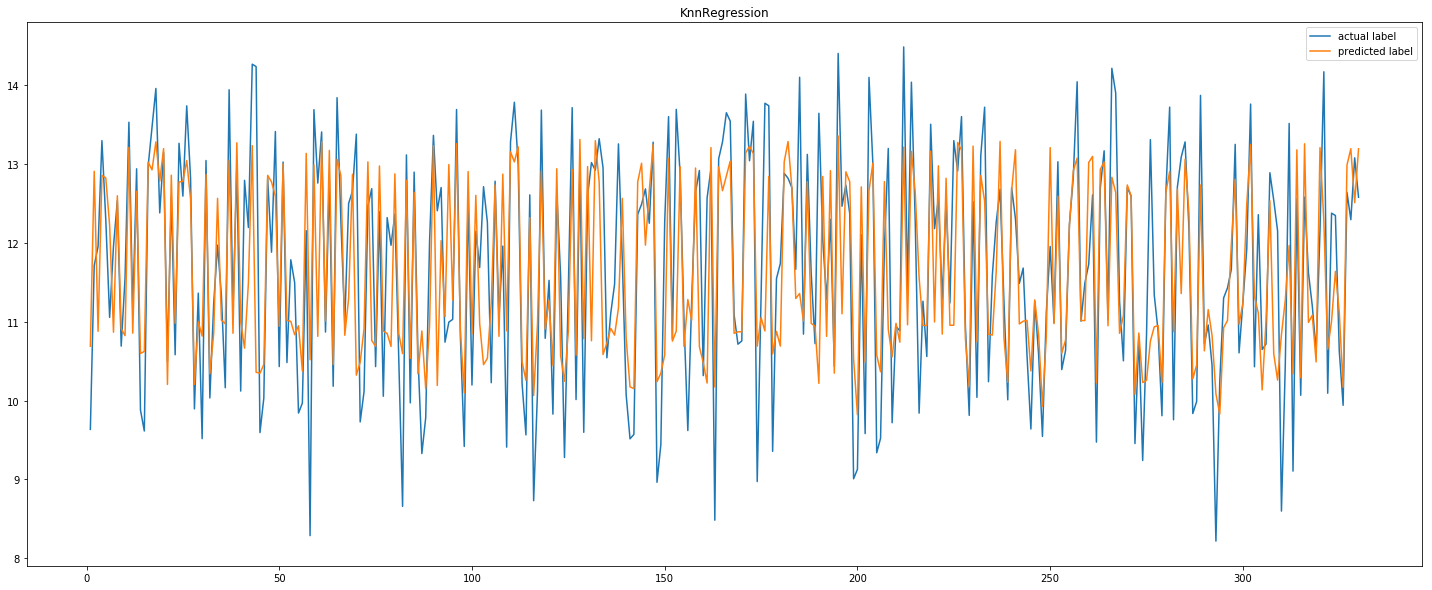

In [579]:
plotRegression("KnnRegression",model)

<h3> Conclusion </h3>
<p> KNeighborsRegressor is the best Regression Model for the given dataset, followed by Ridge with comparable result and finally by Lasso which performs worse than the previous two. </p>